# Houses for Zack:
###  1st EDA Project - Week 3 of Data Science Bootcamp @ neuefische GmbH

#### The dataset: 
"King County House prices" - Information about ~22k houses sold in Seattle in the years 2014/2015

#### The stakeholder: 
Zachary Brooks - Invests in historical houses, best neighborhoods, high profits, best timing within a year, should renovate?

|Questions   |  Hypothesis |  Indicators |
|---|---|---|
| Where are most historical houses?     | 1. Predominantly near the water                                           |  Build date, geolocation | 
| How does age affect the house price?  |  2. Positive, if well maintained                                   | Renovation date  | 
|                                       |  3. Negative, if too small                                         | Squarefootage | 
|  When is the best time to sell?       |  4. Probably summer, because houses look more appealing to buyers. | Selling date, price difference to similar houses in neighborhood  |
|  How important is renovating?     |  5. Renovating increases resale value                                     | Renovation date, relative price  |
|                                       |  6. Renovation is more important in old houses 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(12,8),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from matplotlib.ticker import PercentFormatter
import plotly.express as px
from datetime import datetime, date, time, timedelta
from scipy.stats.mstats import winsorize

##### Defining some functions for easy filtering and binning of the dataset down the line

In [49]:
def renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] > 0]

def not_renovated(dataframe):
    return dataframe[dataframe["yr_renovated"] == 0]

def old(dataframe, yr= 1945):
    return dataframe[dataframe["yr_built"] < yr]

def new(dataframe, yr=1945):
    return dataframe[dataframe["yr_built"] >= yr]

def water(dataframe):
    return dataframe[dataframe["waterfront"] == 1]

def binby(dataframe, column, bins=5, lab = True):
    nbins = bins
    bin_borders = np.arange(dataframe[column].min(), dataframe[column].max()+(dataframe[column].max()*0.01), ((dataframe[column].max()+(dataframe[column].max()*0.01))-dataframe[column].min())/nbins)
    if lab == False:
        binned_column = pd.cut(dataframe[column], bins= bin_borders, labels = lab, include_lowest= True)
    else:
        binned_column = pd.cut(dataframe[column], bins= bin_borders, labels = bin_borders[:-1], include_lowest= True)
    binned_column.name = column+"_bin"
    return pd.concat([dataframe, binned_column], axis=1)

##### Load Data

In [36]:
df= pd.read_csv("data/King_County_House_prices_dataset.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,...,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,...,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,...,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,...,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,...,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


##### Transformation of the dataframe:
Convert date to datetime and extract month to test hypothesis Nr. 4

In [37]:
df.date = pd.to_datetime(df.date)
df["month"] = df.date.dt.month

Replace empty information about renovations

In [38]:
df.yr_renovated = df["yr_renovated"].fillna(-1)

Binning the prices, house sizes and construction years using the pre-defined binning function

In [39]:
df = binby(df, "sqft_living", 5)
df = binby(df, "yr_built", 5)

Group houses by zipcode, house size and construction year using the defined bins

In [40]:
df["avg_price_of_group"] = df.groupby(["zipcode","sqft_living_bin", "yr_built"])["price"].transform("mean")

Determine the relative price difference (in %) of each house, compared to all others in the same group

In [41]:
df["relative_price_bin"] = ((df["price"]/ df["avg_price_of_group"]) -1)*100

Added new columns with information about wether the house has been renovated or not and the time since the last renovation.
If the house has never been renovated, the time since the house was built is used.

In [45]:
renovated_houses = renovated(df)
renovated_houses["yr_since_reno"] = 2015- df.yr_renovated
renovated_houses["renovated"] = "Renovated"
not_renovated = not_renovated(df)
not_renovated["yr_since_reno"]= 2015 - not_renovated.yr_built
not_renovated["renovated"] = "Never renovated"
unknown_reno = df[df["yr_renovated"]==-1]
#unknown_reno["yr_since_reno"] = np.nan
df = pd.concat([renovated_houses, not_renovated, unknown_reno], axis = 0)


(21597, 28)

Added categorical column, showing wether the house is considered historical (built before 1945) or more modern.

In [51]:
historicals =  old(df)
historicals["age"] = "historical"
moderns =  new(df)
moderns["age"] = "modern"
df= pd.concat([historicals, moderns]).sort_index()

# 1st Plot - Renovating or not?

#### General impact of renovation on relative house prices:

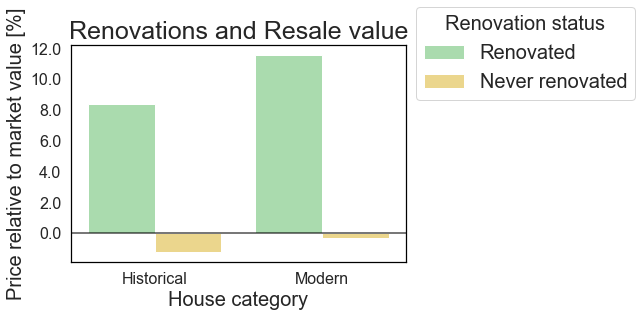

In [54]:
plot1 = sns.barplot(data= df, x="age", y="relative_price_bin", hue="renovated",order=["historical", "modern"], hue_order=["Renovated", "Never renovated"],  ci= None)
colors = ["#FBDE7D", "#F1A49E"]
sns.set_palette(sns.color_palette(colors))
plot1.set_xlabel("House category", fontsize=20)
plot1.set_ylabel("Price relative to market value [%]", fontsize=20)
plot1.set_title("Renovations and Resale value", fontsize= 25)
plot1.legend(loc='lower left', title="Renovation status", title_fontsize = 20, fontsize= 20, bbox_to_anchor=(1, 0.7))
plt.axhline(0, alpha=0.7, color="black")
plot1.set_yticklabels(plot1.get_yticks(), size = 16)
plot1.set_xticklabels(labels =["Historical","Modern"], size=16);

This plot shows the impact of renovations on the price increase a house can achieve compared to others in its class.
But this effect seems weaker in historical houses. Maybe houses that have been restored 60+ years ago distort this analysis.


Added categorical column, showing wether the house has been renovated recently (<10 years), at some point in time or never

In [ ]:
recently = renovated(df[df["yr_since_reno"]<=10])
recently["rec_renovated"] = "recently"
non_recent = renovated(df[df["yr_since_reno"]>10])
non_recent["rec_renovated"] = "not_recent"
never_renovated = not_renovated(df)
never_renovated["rec_renovated"] = "never"
unknown_reno["rec_renovated"] = np.nan
df = pd.concat([recently, non_recent, never_renovated, unknown_reno], axis = 0).sort_index()

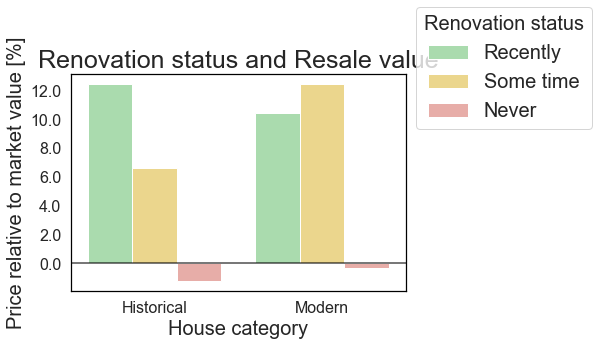

In [56]:
plot1 = sns.barplot(data= df, x="age", y="relative_price_bin", hue="rec_renovated",order=["historical", "modern"], hue_order=["recently", "not_recent", "never"], ci= None)
colors = ["#A2E3A7", "#FBDE7D", "#F1A49E"]
sns.set_palette(sns.color_palette(colors))
plot1.set_xlabel("House category", fontsize=20)
plot1.set_ylabel("Price relative to market value [%]", fontsize=20)
plot1.set_title("Renovation status and Resale value", fontsize= 25)
plot1.legend(loc='lower left', title="Renovation status", title_fontsize = 20, fontsize= 20, bbox_to_anchor=(1, 0.7), labels=["Recently", "Some time", "Never"])
plt.axhline(0, alpha=0.7, color="black")
plot1.set_yticklabels(plot1.get_yticks(), size = 16)
plot1.set_xticklabels(labels =["Historical","Modern"], size=16);

This plot shows that historical houses benefit much more from very recent renovations than modern houses.
There might be a trend going on, where historical houses are upgraded to high-end modern housing.

Historical houses that have never been renovated, however seem to sell lower than other houses in their class.
These houses might be in quite bad condition.

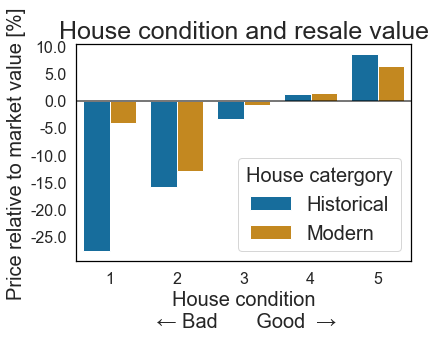

In [61]:
plot2 = sns.barplot(data=df, x="condition", y="relative_price_bin", hue="age", ci= None, hue_order=["historical", "modern"])
sns.set_palette("colorblind",2)
plot2.set_xlabel("House condition\n ← Bad       Good  →", fontsize=20)
plot2.set_ylabel("Price relative to market value [%]", fontsize=20)
plot2.set_title("House condition and resale value", fontsize= 25)
plot2.legend(loc='lower right', title="House catergory", title_fontsize = 20, fontsize= 20, labels=['Historical', 'Modern'])
plt.axhline(0, alpha=0.7, color="black")
plot2.set_yticklabels(plot2.get_yticks(), size = 16)
plot2.set_xticklabels(list(range(1,6)), size=16);

As expected, bad house conditions can drastically lower the price of a house.  

Interesingly, both very good and a very bad conditions seem to have higher impacts on the relative selling prices of historical houses.

# 2nd Plot - What month?

In [ ]:
sns.barplot(data= df, x="month", y="relative_price_bin", hue="age", ci=None, palette="pastel")


In [ ]:
plot3= sns.barplot(data= df, x="month", y="relative_price_bin", hue="age", ci=None, hue_order=["historical", "modern"])#.set(xlabel = 'Percent over market value', ylabel='Month of sale', title='Relative selling prices per month')
sns.set_palette("colorblind",2)
plot3.set_xlabel("Month of sale", fontsize=20)
plot3.set_ylabel("Price relative to market value [%]", fontsize=20)
plot3.set_title("Relative selling prices per month", fontsize= 25)
plot3.legend(loc='upper right', title="House catergory", title_fontsize = 20, fontsize= 20, labels=['Historical', 'Modern'])
plt.axhline(0, alpha=0.7, color="black")
plot3.set_yticklabels(plot3.get_yticks(), size = 16)
plot3.set_xticklabels(list(range(1,13)), size=16)

In [ ]:
def old(dataframe, yr= 1945):
    return dataframe[dataframe["yr_built"] < yr]

def new(dataframe, yr=1945):
    return dataframe[dataframe["yr_built"] >= yr]



In [ ]:
olds= old(df)
olds["big_sales_per_month"] = olds[olds["relative_price_bin"]>0].groupby("month")["id"].transform("count")
news= new(df)
news["big_sales_per_month"] = news[news["relative_price_bin"]>0].groupby("month")["id"].transform("count")
df = pd.concat([olds, news], axis = 0).sort_index()

olds= old(df)
olds["bad_sales_per_month"] = olds[olds["relative_price_bin"]<0].groupby("month")["id"].transform("count")
news= new(df)
news["bad_sales_per_month"] = news[news["relative_price_bin"]<0].groupby("month")["id"].transform("count")
df = pd.concat([olds, news], axis = 0).sort_index()
df["monthly_sales"] = df.groupby("month")["id"].transform("count")


In [ ]:
plot4= sns.barplot(data= df, x= "month", y="big_sales_per_month", hue="age", hue_order=["historical", "modern"])
sns.set_palette("colorblind",2)
plot4.set_xlabel("Month of sale", fontsize=20)
plot4.set_ylabel("Sales count", fontsize=20)
plot4.set_title("Monthly sales above market value", fontsize= 25)
plot4.legend(loc='upper right', title="House catergory", title_fontsize = 20, fontsize= 20, labels=['Historical', 'Modern'])
plt.axhline(0, alpha=0.7, color="black")
plot4.set_yticklabels(plot4.get_yticks(), size = 16)
plot4.set_xticklabels(list(range(1,13)), size=16)

In [ ]:
sns.barplot(data= df, x= "month", y="monthly_sales",color="#5f74a0", saturation=1)

In [ ]:
df["monthly sales"] = df.groupby("month")["id"].transform("count")
df

# 3rd Plot - Location of Interesting properties
Where are the most lucrative?

To buy: Old houses that have not been renovated

In [ ]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin"]>25]), lat="lat", lon = "long", title ="Historical houses that sold more than 25% over market value",labels={"never": "Never", "not_recent": "Some time", "recently":"Recently"}, mapbox_style ="stamen-terrain", zoom =10, width = 800, height=800, color = "renovated", color_discrete_map={
                "recently": "green",
                "not_recent": "goldenrod",
                "never": "red"})
locations.show()

In [ ]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin"]>=0][df["sqft_living"] < 3300]), lat="lat", lon = "long", title ="Historical houses that sold more than 25% over market value",labels={"never": "Never", "not_recent": "Some time", "recently":"Recently"}, mapbox_style ="stamen-terrain", zoom =10, width = 800, height=800, color = "renovated", color_discrete_map={
                "recently": "green",
                "not_recent": "goldenrod",
                "never": "red"})
locations.show()

In [ ]:
sns.scatterplot(data= old(df[df["relative_price_bin"] != 0]), x="relative_size", y="relative_price_bin", hue="renovated")

In [ ]:
old(df[df["relative_price_bin"]>0]).sort_values("relative_price_bin",ascending=False)
sns.histplot(data= old(df[df["relative_price_bin"]>0]), x="relative_price_bin", bins=20)
plt.xlim(-0.2,3.5)

In [ ]:
old(df[df["relative_price_bin"]>0]).sort_values("relative_price_bin",ascending=False)
sns.histplot(data= new(df[df["relative_price_bin"]>0]), x="relative_price_bin", bins=30)
plt.xlim(-0.2,3.5)

In [ ]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin"]>=0]), lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =10, width = 800, height=800, color = "renovated", color_continuous_scale=px.colors.sequential.Rainbow)
locations.show()

In [ ]:
locations = px.scatter_mapbox(not_renovated(old(df)), lat="lat", lon = "long", title ="Unrenovated historical houses, colored by maximum profit in the zipcode area",mapbox_style ="stamen-terrain", zoom =10, width = 800, height=800, color = "relative_price_bin", color_continuous_scale=px.colors.sequential.Rainbow)
locations.show()



In [ ]:
old(df).relative_price_bin

In [ ]:
a = old(df[df["relative_price_bin"] > 1]).mean()
b= old(df[df["relative_price_bin"] < 1]).mean()
c= pd.concat([a,b], axis = 1, copy=False, keys=("good","bad"))
c= c.transpose()
c

In [ ]:
plot6 = sns.scatterplot(data= old(df[df["relative_price_bin"] != 0]),x="price",y="relative_price_bin", hue="renovated", hue_order=["recently", "not_recent", "never"])
colors = ["#A2E3A7", "#FBDE7D", "#F1A49E"]
sns.set_palette(sns.color_palette(colors))
plot6.set_xlabel("House price", fontsize=20)
plot6.set_ylabel("Price relative to market value [%]", fontsize=20)
plot6.set_title("Relation of Profit and Price", fontsize= 25)
plot6.legend(loc='upper right', title="Renovation status", title_fontsize = 20, fontsize= 20)#, labels=["Recently","Some time", "Never"])
plt.axhline(0, alpha=0.7, color="black")
plot6.set_yticklabels(plot6.get_yticks(), size = 16)
plot6.set_xticklabels(list(range(1,13)), size=16)

In [ ]:
plot6 = sns.scatterplot(data= old(df),x="sqft_living",y="relative_price_bin", hue="renovated", hue_order=["recently", "not_recent", "never"])
colors = ["#50af58", "#f9cc39", "#e6564c"]
sns.set_palette(sns.color_palette(colors))
plot6.set_xlabel("Living space [sqft]", fontsize=20)
plot6.set_ylabel("Price relative to market value [%]", fontsize=20)
plot6.set_title("Relation of the size of historic houses to their relative selling prices", fontsize= 25)
plot6.legend(loc='upper right', title="Renovation status", title_fontsize = 20, fontsize= 20)#, labels=["Recently","Some time", "Never"])
plt.axhline(0, alpha=0.7, color="black")
plt.xlim(0,6e3)
plot6.set_yticklabels(plot6.get_yticks(), size = 16)
plot6.set_xticklabels(plot6.get_xticks(), size=16)


In [ ]:
old(df[df["relative_price_bin"] < 1]).mean()

In [ ]:
locations = px.scatter_mapbox(old(df[df["relative_price_bin"] > 0]), lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =9,  width = 800, height=500, color = "condition")
locations.show()

In [ ]:
locations = px.scatter_mapbox(df, lat="lat", lon = "long", mapbox_style ="stamen-terrain", zoom =9,  width = 800, height=500, color = "relative_price_bin", color_continuous_scale=px.colors.diverging.RdBu)
locations.show()

# 4. Plot - How big are the most lucrative old houses?

In [ ]:
sns.barplot(data=old(df), x="sqft_living_bin", y="relative_price_win", hue="renovated", palette = "pastel", ci= None)
plt.axhline(0, alpha=0.5)

In [ ]:
sns.scatterplot(data=old(df), x="relative_size", y="relative_price_bin", hue="bathrooms")
plt.axhline(0)
plt.axvline(1)
plt.xlim(0,6.3)
plt.ylim(-1.2,10)

In [ ]:
sns.scatterplot(data=new(df), x="relative_size", y="relative_price_win", hue="bathrooms", palette="icefire")
plt.axhline(0)
plt.axvline(1)
plt.xlim(0,6.3)
plt.ylim(-1.2,10)

# Recommendations:
## 1. Renovate houses before selling / Buy unrenovated
    - recent renovations (<10 years) increase resale value of historicals more
    - bad condition reduces price of historicals much more
## 2. Sell in April
    - Relative selling price largest in April, especially for old houses
    - Month with highest number of sales over market value
    - Seemingly people are more inclined to spend more than marketvalue after winter?
    
## 3. Most lucrative buildings at waterfront
    - No surprise here
## 4. Invest in Large/Small houses

In [ ]:
df.groupby("sqft_living_bin")[["relative_price_bin"]].describe()

In [ ]:
df.groupby("yr_built_bin")[["relative_price_bin"]].describe()

In [ ]:
df["max_profit_of_zipcode"]= df.groupby("zipcode")[["relative_price_bin"]].transform("max")

In [ ]:
df.head()